<a href="https://colab.research.google.com/github/AntonioCCosta/DPG_PhysicsBehavior_2026/blob/main/notebooks/notebook_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Physics of Behavior Tutorial II - Part 1

Animal behavior is intrinsically multiscale in nature. Yet, most descriptions focus on specific timescales of interest, and miss out on the interactions across timescales. In this tutorial, we will introduce guiding principles for building a multiscale description of behavior. In particular, we will use the notion of timescale separation for distinguishing behavioral states from transitions on different timescales, using the language of transfer operators.

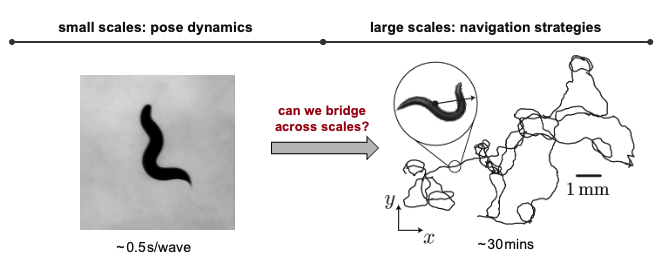


We have split the tutorial notebooks into 4 sections, starting with a theoretical presentation of the use of transfer operators for coarse-graining dynamics through a timescale separation ([Notebook 1](https://colab.research.google.com/github/AntonioCCosta/DPG_PhysicsBehavior_2026/blob/main/notebooks/notebook_1.ipynb)), then moving into a couple of toy data examples ([Notebook 2](https://colab.research.google.com/github/AntonioCCosta/DPG_PhysicsBehavior_2026/blob/main/notebooks/notebook_2.ipynb) and [Notebook 3](https://colab.research.google.com/github/AntonioCCosta/DPG_PhysicsBehavior_2026/blob/main/notebooks/notebook_3.ipynb)), and finally ended with a real-world data application to C. elegans posture dynamics ([Notebook 4](https://colab.research.google.com/github/AntonioCCosta/DPG_PhysicsBehavior_2026/blob/main/notebooks/notebook_4.ipynb)).


Before we start, load the following python packages:

In [4]:
# Environment setup
!pip install -q -r https://raw.githubusercontent.com/AntonioCCosta/DPG_PhysicsBehavior_2026/main/requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.2/40.2 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 16.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 60.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 920.8/920.8 kB 42.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 488.6/488.6 kB 31.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 31.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.3/72.3 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.6/58.6 kB 5.1 MB/s eta 0:00:00


In [5]:
import os

if not os.path.exists("DPG_PhysicsBehavior_2026"):
    !git clone https://github.com/AntonioCCosta/DPG_PhysicsBehavior_2026.git
else:
    %cd DPG_PhysicsBehavior_2026
    !git pull
    %cd ..

import sys, platform
print("Python:", sys.version)
print("Platform:", platform.platform())

Cloning into 'DPG_PhysicsBehavior_2026'...
remote: Enumerating objects: 152, done.
remote: Counting objects: 100% (152/152), done.
remote: Compressing objects: 100% (129/129), done.
remote: Total 152 (delta 71), reused 38 (delta 12), pack-reused 0 (from 0)
Receiving objects: 100% (152/152), 25.98 MiB | 9.87 MiB/s, done.
Resolving deltas: 100% (71/71), done.
Python: 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
Platform: Linux-6.6.113+-x86_64-with-glibc2.35


In [6]:
import h5py
import numpy as np
import numpy.ma as ma
sys.path.append('./DPG_PhysicsBehavior_2026/utils')
import operator_calculations as op_calc
import delay_embedding as embed
import partition_methods as cl
import coarse_graining as cgm
import matplotlib.pyplot as plt

## Stochastic dynamics on a 1d double well

From an abstract perspective, we will think of behavior as a dynamical system,

$$
\dot{\mathbf{x}} = f(\mathbf{x},\theta),
$$

where $\mathbf{x}\in \mathbb{R}^D$ represents the behavioral state, which corresponds to the full set of variables needed to predict the future behavioral state, $\theta$ is an unknown set of parameters, and $f$ is a nonlinear noisy function of the state.

Generally speaking, when studying animal behavior, we don't have access to $f$ or $\theta$, or not even $\mathbf{x}$, but in this tutorial we will see how we can still learn effective models and representations of behavior spanning multiple timescales.

To gain intuition of the theoretical approach, let's start with a simple system, for which the long-lived dynamics can be derived analytically.

We will be considering overdamped Langevin dynamics on a potential landscape,

$$
\dot{x} = -\partial_x V(x) + \sqrt{2 T_x}\,\eta(t),
\qquad \langle \eta(t)\eta(t') \rangle = \delta(t-t').
$$

Where the potential landscape is a double well:

$$
V(x) = \frac{x^4}{4} -\mu \frac{x^2}{2}
$$

For $\mu>0$, we have two stable fixed points with an energy barrier in between. You can think of each well as representing a behavioral state, and the transition dynamics as being set by stochastic transitions among wells.


> Comment: while the full dynamics should include position and momentum, we here study the **overdamped** limit for simplicity. By overdamped we mean that velocity fluctuations are much faster that the position fluctuations, since friction is much larger than the mass (see e.g. Risken, *The Fokker-Planck Equation: Methods of Solution and Applications*, 1989), and so we can effectively neglect the velocity dynamics. This holds, for example, for tiny particles in viscuous fluids.




Let's see what the dynamics looks like by making some simulations using a simpler Euler scheme


In [7]:
from numba import jit,prange
@jit(nopython=True, parallel=True)
def simulate_dw(x0s,mu, Tx, dt, max_iters,downsampling):
    n_sims = len(x0s)
    sims = np.zeros((n_sims, int(max_iters/downsampling)))
    for ks in prange(n_sims):
        x0 = x0s[ks]
        x = x0
        for i in range(max_iters):
            new_x = x + (-x**3+mu*x) * dt + np.sqrt(2 * Tx) * np.random.normal(0, np.sqrt(dt))
            x = new_x
            if i%downsampling==0:
                sims[ks, int(i/downsampling)] = x
    return sims

As you can see, depending on the value of $\mu$ the macroscopic properties of the dynamics change. When $\mu<0$ we have one stable fixed point, whereas $\mu > 0$ induces a pitchfork bifurcations with two stable fixed points trapping the dynamics on long timescales

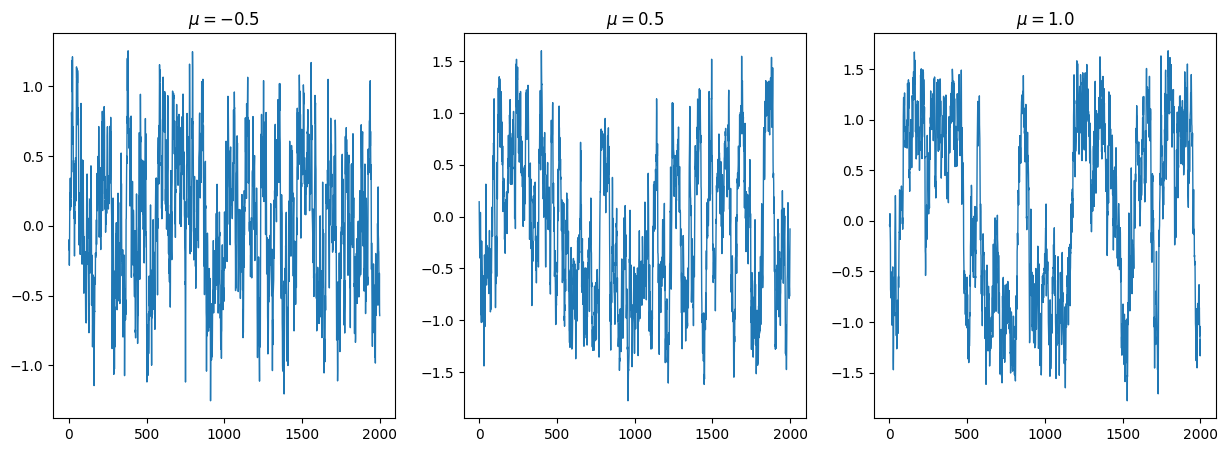

In [8]:

#set simulation parameters
Tx=2.5e-1 #temperature
T = 200
dt=1e-3
max_iters=int(T/dt)
final_dt = 1e-1
downsampling = int(final_dt/dt)

plt.figure(figsize=(15,5))
mu_vals = [-0.5,0.5,1]
for k in range(len(mu_vals)):
  mu=mu_vals[k]
  x0s = np.random.uniform(-1,1,1)
  sim = simulate_dw(x0s,mu, Tx, dt, max_iters,downsampling)[0]
  plt.subplot(1,3,k+1)
  plt.title(r'$\mu = {:.1f}$'.format(mu))
  plt.plot(sim,lw=1)
plt.show()

At large times, the system relaxes to a steady-state distribution, which can be obtained by solving for the stationary solution of the Fokker-Planck equation (see e.g. Risken, *The Fokker-Planck Equation: Methods of Solution and Applications*, 1989),

$$
\partial_t \pi(x,t) = \partial_x\!\left(\partial_x V(x)\,\pi(x,t) \right) + T_x \partial_x^2 \pi(x,t) = -\partial_x J(x,t) = 0,
$$

where $ J(x,t)$ is the probability current. For a confining potential $V(x)$ (such as a double-well potential), normalizability of the stationary distribution implies vanishing current, $J(x) = 0$, leading to

$$
\pi(x) = e^{-V(x)/T_x}/Z,
$$

where Z is a normalization constant (analogous to the partition function). To illustrate this result, we now perform numerical simulations for a fixed value of $\mu$.


In [9]:

Tx=3e-1 #temperature
T = 5000
dt=1e-3
max_iters=int(T/dt)
final_dt = 1e-1
downsampling = int(final_dt/dt)
n_sims = 50
x0s = np.random.uniform(-1,1,n_sims)
mu=1
sims = simulate_dw(x0s,mu, Tx, dt, max_iters,downsampling)

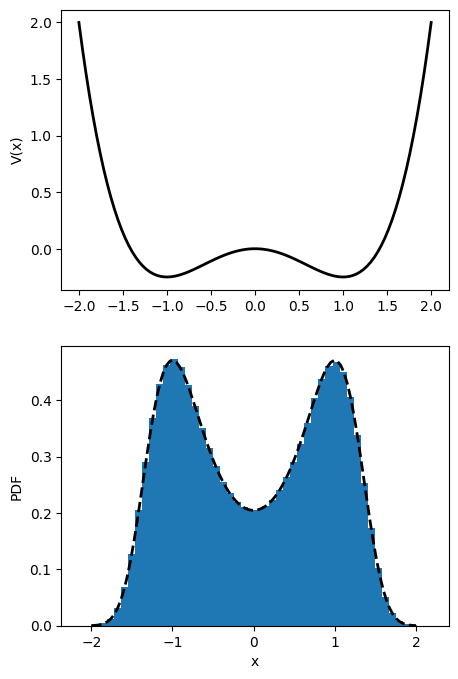

In [10]:
def potential(x,mu):
    return x**4 / 4 - mu * x**2 / 2

x = np.linspace(-2,2,100)
plt.figure(figsize=(5,8))
plt.subplot(2,1,1)
plt.plot(x,potential(x,mu),lw=2,c='k')
plt.ylabel('V(x)')
pB = np.exp(-potential(x,mu)/Tx)
Z = np.trapezoid(pB,x)
pB =pB/Z
plt.subplot(2,1,2)
plt.hist(np.hstack(sims),bins=50,density=True,label='sim')
plt.plot(x,pB,c='k',ls='--',lw=2,label='pB')
plt.xlabel('x')
plt.ylabel('PDF')
plt.show()

Now, besides the long term behavior, we also see that when $\mu>>0$ there is a strong time scale separation between the transitions among wells, and the relaxation to a single well. The time it takes to transition out of a potential well is given by the first passage time distribution (see e.g. Risken, *The Fokker-Planck Equation: Methods of Solution and Applications*, 1989),

$$
f(t,\omega) = \omega e^{-\omega t}
$$

where $\omega=1/\tau_\text{MFPT}$ is the inverse of the mean first passage time $\tau_\text{MFPT}$.

Considering that the particle starts at a minimum of the potential well $x_0=a$ and escapes when reaching the barrier situated at $x_f = b$, and assuming reflective boundary conditions at $x_0=a$ and an absorbing boundary at $x_f=b$ (where the escape events occurs), we have a mean first passage time across the barrier of

$$
\tau_\text{MFPT}(x_0) = \frac{1}{\tau_x T_x} \int_{x_0}^b e^{V(y)/T_x}dy \int_a^y  e^{-\beta V(z)/T_x} dz.
$$


Let's see how this compares with the timescales we obtain from our simulations.

In [11]:
from scipy.interpolate import interp1d
from scipy.integrate import cumulative_trapezoid

def exppot(x, Tx,mu,sign=-1, fun=lambda z: 1):
    return np.exp(sign*potential(x,mu)/Tx)*fun(x)

def omega_be(Tx,mu):
    z = np.linspace(-20, 0, 1000)
    iarr = cumulative_trapezoid(exppot(z,Tx,mu), z, initial=0)
    ifun = interp1d(z, iarr)

    y = np.linspace(-1, 0, 1000)
    oarr = cumulative_trapezoid(exppot(y,Tx,mu, sign=1, fun=ifun), y, initial=0)/Tx
    ofun = interp1d(y, oarr)

    return 1/(2*ofun(0))


def transition_time_be(Tx,mu):
    z = np.linspace(-20, 0, 1000)
    iarr = cumulative_trapezoid(exppot(z,Tx,mu), z, initial=0)
    ifun = interp1d(z, iarr)

    y = np.linspace(-1, 0, 1000)
    oarr = cumulative_trapezoid(exppot(y,Tx,mu, sign=1, fun=ifun), y, initial=0)/Tx
    ofun = interp1d(y, oarr)

    return ofun(0)

In [49]:
def state_lifetime(states,tau):
    durations=[]
    for state in np.sort(np.unique(states.compressed())):
        gaps = states==state
        gaps_boundaries = np.where(np.abs(np.diff(np.concatenate([[False], gaps, [False]]))))[0].reshape(-1, 2)
        durations.append(np.hstack(np.diff(gaps_boundaries))*tau)
    return durations

delta = 0.2 * np.sqrt(mu) #this ensures that we only count true transitions among states and not short time fluctuations just across the boundary
xs = np.hstack(sims)
states = np.zeros_like(xs)
states[xs >  delta] = +1
states[xs < -delta] = -1
states = np.ma.masked_equal(states, 0)
ds=5 #to further remove fast fluctuations
durs = np.hstack(state_lifetime(states[::ds],ds*final_dt))

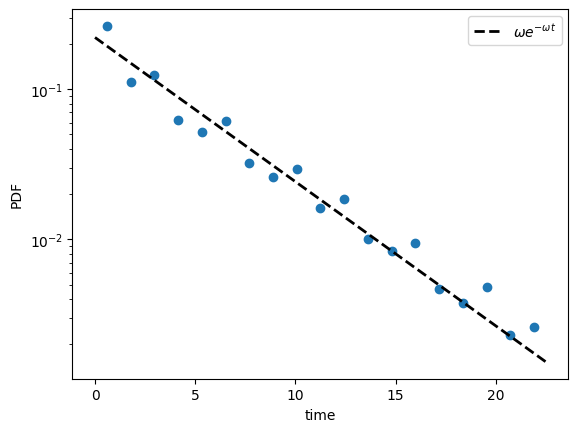

In [51]:
tmin=0
tmax=np.percentile(durs,99)
freqs,bin_edges = np.histogram(durs, bins=np.linspace(tmin,tmax,20), density=True)
centers = (bin_edges[1:]+bin_edges[:-1])/2
plt.scatter(centers,freqs,marker='o')
times = np.linspace(tmin,tmax,10)
plt.plot(times,1/transition_time_be(Tx,mu)*np.exp(-times/transition_time_be(Tx,mu)),c='k',lw=2,ls='--',label=r'$\omega e^{-\omega t}$')
plt.yscale('log')
plt.ylabel('PDF')
plt.xlabel('time')
plt.legend()
plt.show()

In [69]:
print(transition_time_be(Tx,mu))

4.523120017963122


# Extracting slow modes through a transfer operator picture of the dynamics

Using the methods above, we could use our knowledge of the potential landscape to direclty infer the transition boundary and the time it takes to transition across.

However, in most complex systems, the long-lived properties of the dynamics are not immediately apparent from the equations, and analytical solutions are challenging to obtain.

Nonetheless, we can still use the Fokker-Planck dynamics, and particularly the structure to the transfer operator evolving the dynamics, to directly uncover the slow modes of the dynamics.


Returning to can write the Fokker-Planck equation for the density $\rho$ dynamics,

$$
\dot{\rho}(x,t) = \partial_x\left(\partial_x V(x) \rho(x,t) \right) + T_x\partial_x^2 \rho(x,t),
$$

which we can rewrite as,

$$
\dot{\rho}(x,t) = L \rho(x,t)
$$

where $L = \partial_x\left(\partial_x V(x) \cdot \right) + T_x\partial_x^2\cdot$, is the forward Fokker-Planck operator, a linear operator that determines the evolution of probability distributions in the state space driven by the nonlinear Langevin dynamics encoded in $V(x)$. Encoding the nonlinear dynamics through a linear operator is extremely powerful, as the operator's eigenvalues and eigenvectors directly capture the timescales of the system and the corresponding directions, as we'll see in detail below.

But before we get there, let's first gain intution for structure of this operator by approximating it numerically.

## Finite-difference estimator of the transfer operator

We can numerically approximate $L$ through a finite-difference estimator. Here, we will make use of the Chang-Cooper method (Change, Cooper. *A Practical Difference Scheme for Fokker-Planck Equations*. J. Comput. Physics 1969)

In [52]:
import scipy.sparse as sp
import scipy.sparse.linalg as spla


def fokker_planck_L_sg(x, mu, Tx, tau_x=1.0, boundary="reflecting",potential=None):
    """
    Build L for ∂_t p = ∂_x(∂_x V p) + Tx ∂_x^2 p on a uniform grid x (Chang-Cooper).
    potential(x): callable returning V(x)
    """
    x = np.asarray(x); N = x.size
    dx = x[1] - x[0]; D = Tx

    # Bernoulli function
    def B(z):
        out = np.empty_like(z)
        small = np.abs(z) < 1e-8
        out[~small] = z[~small] / np.expm1(z[~small])
        zS = z[small]
        out[small] = 1 - zS/2 + zS**2/12
        return out

    V = potential(x,mu)
    dV_face = V[1:] - V[:-1]
    psi = -(dV_face) / D

    a = (D / dx**2) * B(psi)      # coeff to node i+1 from face i+1/2
    b = (D / dx**2) * B(-psi)     # coeff to node i   from face i+1/2

    diag  = np.zeros(N)
    upper = np.zeros(N-1)
    lower = np.zeros(N-1)

    # interior
    diag[1:-1]  = -(b[1:] + a[:-1])
    upper[1:-1] =  a[1:-1]
    lower[0:-1] =  b[0:-1]

    if boundary == "reflecting":
        diag[0]   = -b[0];   upper[0]  =  a[0]
        diag[-1]  = -a[-1];  lower[-1] =  b[-1]; upper[-1] =  a[-1]
    elif boundary == "absorbing":
        diag[0] = upper[0] = 0.0
        diag[-1] = lower[-1] = 0.0
        lower[0] = 0.0
        upper[-1] = 0.0
    else:
        raise ValueError("boundary must be 'reflecting' or 'absorbing'")

    L = sp.diags([lower, diag, upper], offsets=[-1,0,1], format="csc")
    return (1.0/tau_x)*L

In [62]:
N = 1000

x_min, x_max = -np.sqrt(np.abs(mu))-2*np.sqrt(Tx),np.sqrt(np.abs(mu))+2*np.sqrt(Tx)
x = np.linspace(x_min, x_max, N)
tau_x=1
delay=1e-1
V = lambda x,mu: x**4 / 4 - mu * x**2 / 2

L_fp = fokker_planck_L_sg(x,mu,Tx,tau_x,potential=V)

Now we can directly simulate the dynamics of the entire probability distribution function, rather than a single trajectory. For example, starting from a delta function, we can evolve the dynamics by taking,

$$
\rho(t+\tau) = P_\tau \rho(t),
$$

where $P_\tau = e^{L \tau}$ is the discrete time transition matrix, also known as the forward propagator.



In [63]:
print('Obtain transition matrix')
P_tau = spla.expm(delay * L_fp)

print('Iterate probability distribution function')
p0 = np.zeros(P_tau.shape[0]) # set initial condition as a delta function
p0[200] = 1
n_iters=100
p=p0
ps=np.zeros((n_iters,p.shape[0]))
ps[0]=p
for k in range(1,n_iters): #iterate the dynamics
    p = P_tau @ p
    ps[k]=p

Obtain transition matrix
Iterate probability distribution function


You can now observe the relaxation of the probability distribution to the steady state, which we know is given by the Boltzmann distribution

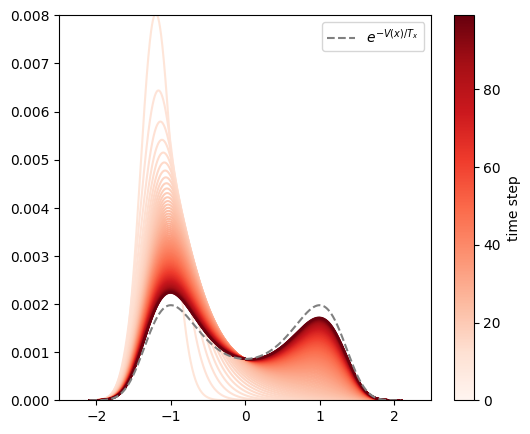

In [64]:
import matplotlib as mpl

ds = 1
n = int(len(ps)/ds)
colors_c = plt.cm.Reds(np.linspace(0.1, 1, n))

plt.figure(figsize=(6,5))
for k, k_ in enumerate(np.arange(1, len(ps), ds)):
    p = ps[k_]
    plt.plot(x, p, c=colors_c[k])

plt.xlim(-2.5, 2.5)
plt.ylim(0, 0.008)

norm = mpl.colors.Normalize(vmin=0, vmax=n-1)
sm = mpl.cm.ScalarMappable(cmap=plt.cm.Reds, norm=norm)
sm.set_array([])

ax = plt.gca()
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label("time step")
pB = np.exp(-V(x,mu)/Tx)
pB = pB/np.sum(pB)
plt.plot(x,pB,c='gray',ls='--',label=r'$e^{-V(x)/T_x}$')
plt.legend()
plt.show()


In [65]:
## For an animation uncomment this code

# import matplotlib.animation as animation
# from IPython.display import HTML
# import matplotlib as mpl

# ds = 1
# frames = np.arange(1, len(ps), ds)

# fig, ax = plt.subplots(figsize=(6,5))

# line, = ax.plot([], [], lw=2)
# line_B, = ax.plot([], [], c='gray', ls='--', label='pB')

# ax.set_xlim(-1.8, 1.8)
# ax.set_ylim(0, 0.014)
# ax.set_xlabel("x")
# ax.set_ylabel("p(x,t)")

# # Boltzmann reference
# pB = np.exp(-V(x,mu)/Tx)
# pB = pB / np.sum(pB)
# line_B.set_data(x, pB)

# # Color map
# cmap = plt.cm.Reds
# norm = mpl.colors.Normalize(vmin=0, vmax=len(frames))

# def init():
#     line.set_data([], [])
#     return line, line_B

# def animate(i):
#     p = ps[frames[i]]
#     line.set_data(x, p)
#     line.set_color(cmap(norm(i)))
#     ax.set_title(f"time step = {frames[i]}")
#     return line, line_B

# ani = animation.FuncAnimation(
#     fig, animate, init_func=init,
#     frames=len(frames), interval=30, blit=True
# )

# plt.close(fig)

# HTML(ani.to_jshtml())


## Decomposing the dynamics into it's long-lived modes

The eigenvalues of $L$, $\Lambda_k$ directly capture the relaxation timescales of different eigenvectors. We can directly compute them from the discrete time operaotr $P_\tau$. Indeed, since $P_\tau = e^{L \tau}$ the eigenvalue decomposition yields,

$P_\tau \psi_k = \lambda_k \psi_k = e^{\Lambda_k \tau} \psi_k$, and so $\lambda_k = e^{\Lambda_k \tau}$.


$P_\tau$ always has an eigenvector of eigenvalue 1, which corresponds to the steady-state distribution since it's unchanged when acted by $P_\tau$,

$P_\tau \pi = \pi$. Let's see what that looks like

In [66]:
eigvals_fwd,eigvecs_fwd = op_calc.sorted_spectrum(P_tau,k=5)
pi = eigvecs_fwd[:,0].real/eigvecs_fwd[:,0].real.sum()

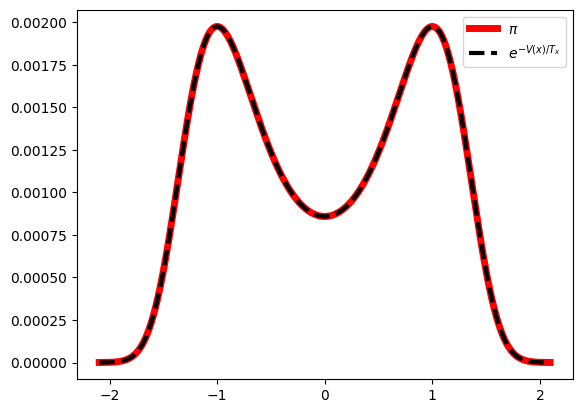

In [67]:
plt.plot(x,pi,c='r',lw=5,label=r'$\pi$')
plt.plot(x,pB,c='k',ls='--',lw=3,label=r'$e^{-V(x)/T_x}$')
plt.legend()
plt.show()

So the first right eigenvector of $P_\tau$ corresponds to the steady-state distribution. The remaining eigenvectors decay to the steady-state distribution on a timescale given by

$$
\Lambda^{-1}_k = -\frac{\tau}{\log \lambda_k}.
$$

In this case, the slowest non-trivial mode corresponds to the time it takes to escape a potential well. Let's compare it against the analytical result for the mean first passage time




In [68]:
transition_time_be(Tx,mu),-delay/np.log(eigvals_fwd[1].real)

(array(4.52312002), np.float64(4.201264833548611))

The left eigenvectors of the operator $\phi_1$ capture directions in the state-space that communicate the least: parts of the state space that follow each other in time have similar $\phi_1$ values, whereas parts of the state space for which is takes a long time to transition between have different values of $\phi_1$.

In [ ]:
_,eigvecs_bw = op_calc.sorted_spectrum(P_tau.T,k=5)

eigvecs_bw = eigvecs_bw.real
eigvecs_bw = eigvecs_bw/np.linalg.norm(eigvecs_bw,axis=0)

phi2 = eigvecs_bw[:,1]

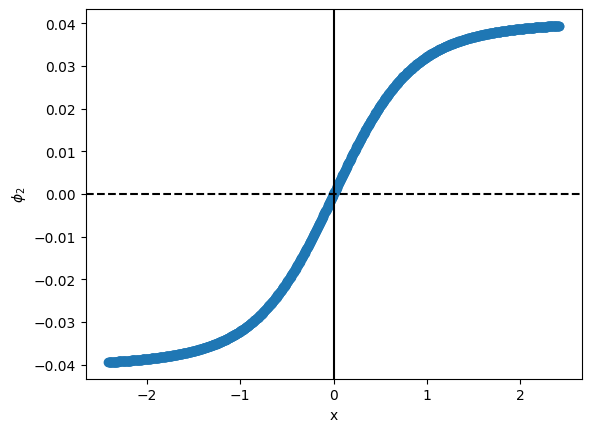

In [ ]:
plt.scatter(x,phi2)
plt.axvline(0,c='k')
plt.axhline(0,c='k',ls='--')
plt.ylabel(r'$\phi_2$')
plt.xlabel('x')
plt.show()

More generally, in systems for which the location of the border between metastable states or almost invariant sets is not immediately apparent from the equations of motion, we can still use the structure of the inferred transfer operator to identify such regions.

We call a set $S$ coherent when the system is more likely to remain within the set than it is to leave it within a time $\tau$. We quantify this intuition through

$$
\chi_{\mu,\tau}(S) = \frac{\mu(S\cap \Phi_{-\tau}S)}{\mu(S)} = \frac{\mu(\Phi_\tau S\cap S)}{\mu(S)},
$$

where $\mu$ is the invariant measure preserved by the invertible flow $\Phi_\tau$. Given an inferred transfer operator $P_\tau$ and its associated stationary eigenvector $\pi$, we can immediately compute $\chi$ as

$$
\chi_{\pi,\tau}(S) = \frac{\sum_{i,j\in S}\pi_i P_{ij}(\tau)}{\sum_{i \in S} \pi_i}.
$$

It turns out that the second eigenvector of the reversibilized transfer operator $\phi_2$ provides an optimal subdivision of the state space into almost invariant sets (see Froyland et al Physica D 2005). And so instead of a brute force search for the sets that maximize the coherence, we can search along $\phi_2$ for a maximum of the overall coherence of both sets,
$$
\chi(\phi_2^c) = \text{min}\{\chi_{\pi,\tau^*}(S^+(\phi_2^c)),\chi_{\pi,\tau^*}(S^-(\phi_2^c))\}
$$

where $\{S^+(\phi_2^c),S^-(\phi_2^c)\}$ result from a partition at $\phi_2^c$.

In [ ]:
cr,rho_sets,ms,idx,km_labels = cgm.optimal_partition(phi2,pi,P_tau.T,return_rho=True)

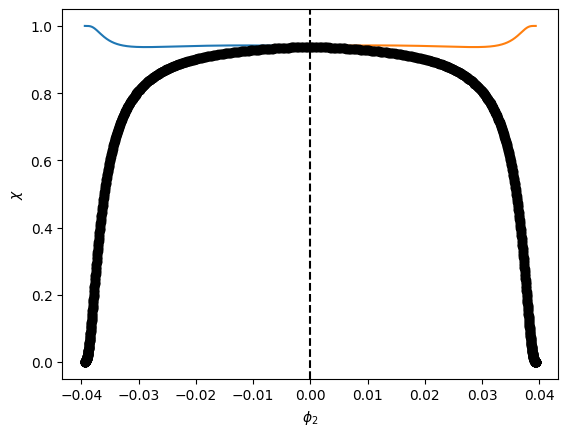

In [ ]:
plt.plot(cr,rho_sets)
plt.plot(cr,np.min(rho_sets,axis=1),marker='o',c='k')
plt.axvline(cr[idx],c='k',ls='--')
plt.ylabel(r'$\chi$')
plt.xlabel(r'$\phi_2$')
plt.show()